# Modeling Notebook

In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Pycaret
from pycaret.classification import *
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the dataset
data = pd.read_csv('../dataset/cardio_train.csv',sep=';')
# Check the data
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [38]:
# Remaining columns are having values like 'yes' and 'no'
for i in data.columns:
    print(i)
    print(data[i].unique())
    print(data[i].nunique())

age
[50.4 55.4 51.6 48.2 47.8 60.  60.5 61.8 48.4 54.3 61.7 51.5 40.5 54.2
 58.3 45.9 47.9 59.6 54.1 58.6 63.1 45.5 39.6 53.5 49.5 39.9 57.7 50.1
 63.5 40.  56.5 60.1 55.9 50.2 49.2 64.  49.6 50.  58.8 56.3 49.8 50.7
 46.2 43.9 49.9 53.6 39.7 53.9 62.3 43.5 52.3 52.4 54.  57.2 64.6 59.9
 64.2 56.1 55.8 52.1 53.8 62.  53.3 63.6 51.3 62.5 52.7 59.8 47.5 40.2
 46.6 42.3 63.8 57.9 51.8 60.4 39.2 49.7 59.2 53.4 60.2 56.  58.2 60.3
 45.8 50.5 64.3 59.4 56.2 61.4 49.1 63.3 48.  41.8 56.4 61.9 58.  51.9
 62.1 53.7 52.2 52.  42.  59.7 51.7 47.4 57.5 58.5 63.9 41.9 43.3 39.4
 55.5 46.  44.  59.5 57.8 63.7 39.8 60.6 51.4 44.1 43.8 52.6 41.7 56.7
 55.6 58.1 45.6 45.4 39.5 44.6 40.4 41.6 44.4 40.1 48.6 42.1 46.1 62.2
 44.7 43.6 64.4 46.4 64.8 61.6 41.4 54.8 62.7 47.7 54.9 40.8 49.4 43.7
 61.5 46.5 54.5 39.3 57.6 53.2 49.3 62.4 48.1 50.3 40.6 45.1 45.3 58.7
 55.7 50.6 47.6 56.6 59.3 45.7 42.2 63.4 46.7 64.7 64.5 54.4 44.2 54.6
 57.3 52.5 64.1 58.4 47.3 42.4 55.3 43.2 44.3 55.2 61.3 41.2 46.8 57.4
 4

#  Data Preprocessing

* I will drop column 'id' as it is irrelevant to target variable.
* Transform age column into years instead of days.
* Gender feature should not be categorized into 1 and 2 because 2 is always numerically bigger than 1, the model would take into account that and give a bigger ratio to one gender for having a disease. So, I will make that binary.
* I will check and drop duplicates.
* i would check for outliars

In [3]:
# There is no mising value in the data.
print(f"Missing values are present: {data.isnull().sum().any()}")

Missing values are present: False


In [4]:
data.drop('id',axis=1,inplace=True)
data.age = np.round(data.age/365.25,decimals=1)
data.gender = data.gender.replace(2,0)

In [5]:
data.duplicated().sum()

674

In [6]:
data.drop_duplicates(inplace=True)

## Checking for Outliers

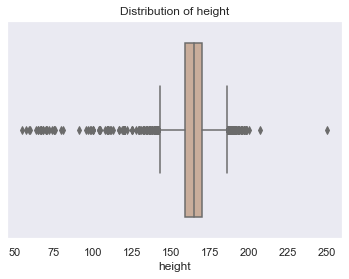

In [8]:
sns.set_style('dark')
sns.boxplot(data.height,palette='pink')
plt.title('Distribution of height');

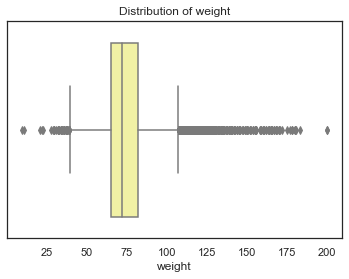

In [9]:
sns.set_style('white')
sns.boxplot(data.weight,palette='terrain')
plt.title('Distribution of weight');

I will remove extremely rare cases of height and weight. As data is quite big, there will be no problem while modelling.

In [7]:
data.drop(data [(data ['height'] > data ['height'].quantile(0.975)) | (data ['height'] < data ['height'].quantile(0.025))].index,inplace=True)
data.drop(data [(data ['weight'] > data ['weight'].quantile(0.975)) | (data ['weight'] < data ['weight'].quantile(0.025))].index,inplace=True)

There are many outliers in height and weight features. I combine both of these into a new feature bmi.

In [8]:
data["bmi"] = (data["weight"]/ (data["height"]/100)**2).round(1)

Now, I will remove outliers and abrupt blood pressure values.

In [9]:
data.drop(data[(data['ap_hi'] > data['ap_hi'].quantile(0.975)) | (data['ap_hi'] < data['ap_hi'].quantile(0.025))].index,inplace=True)
data.drop(data[(data['ap_lo'] > data['ap_lo'].quantile(0.975)) | (data['ap_lo'] < data['ap_lo'].quantile(0.025))].index,inplace=True)

In [10]:
#creating dummy variables for categorical column
data['cholesterol']=data['cholesterol'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})
data['glucose']=data['gluc'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})
data.drop(['height','weight','gluc'],axis=1,inplace=True)
data.head()

,age,gender,ap_hi,ap_lo,cholesterol,smoke,alco,active,cardio,bmi,glucose
0,50.4,0,110,80,normal,0,0,1,0,22.0,normal
1,55.4,1,140,90,well above normal,0,0,1,1,34.9,normal
2,51.6,1,130,70,well above normal,0,0,0,1,23.5,normal
3,48.2,0,150,100,normal,0,0,1,1,28.7,normal
4,47.8,1,100,60,normal,0,0,0,0,23.0,normal


### Modelling

In [11]:
dataset=data.sample(frac=0.9, random_state=20)
data_unseen = data.drop(dataset.index)

dataset.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)
data_unseen.drop(columns=['cardio'],inplace=True)

print('Data for Modeling: ' + str(data.shape))
print("-----------------------------------------------------------")
print('Unseen Data For Predictions: ' + str(data_unseen.shape))
print("-----------------------------------------------------------")

Data for Modeling: (59598, 11)
-----------------------------------------------------------
Unseen Data For Predictions: (5960, 10)
-----------------------------------------------------------


In [12]:
exp01 = setup(data=dataset, 
              target="cardio", 
              session_id=20, 
              feature_selection=True, 
              remove_outliers=True,
              remove_multicollinearity=True,
                )

,Description,Value
0,Session id,20
1,Target,cardio
2,Target type,Binary
3,Original data shape,"(53638, 11)"
4,Transformed data shape,"(52022, 11)"
5,Transformed train set shape,"(36010, 11)"
6,Transformed test set shape,"(16092, 11)"
7,Numeric features,8
8,Categorical features,2
9,Preprocess,True


In [19]:
top_model = compare_models(fold=5,
                            sort="Accuracy",
                            n_select=1,
                            turbo=True
                            )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7258,0.7905,0.6789,0.7409,0.7085,0.4506,0.4522,0.8120
lightgbm,Light Gradient Boosting Machine,0.7245,0.7877,0.6715,0.7427,0.7053,0.4479,0.4500,0.3040
catboost,CatBoost Classifier,0.7234,0.7877,0.6713,0.7410,0.7044,0.4457,0.4477,5.8580
ada,Ada Boost Classifier,0.7220,0.7846,0.6377,0.7577,0.6925,0.4423,0.4478,0.4440
lr,Logistic Regression,0.7201,0.7820,0.6504,0.7468,0.6952,0.4388,0.4424,0.7940
lda,Linear Discriminant Analysis,0.7191,0.7820,0.6392,0.7514,0.6908,0.4364,0.4412,0.2540
ridge,Ridge Classifier,0.7190,0.0000,0.6391,0.7513,0.6907,0.4363,0.4411,0.1480
xgboost,Extreme Gradient Boosting,0.7176,0.7788,0.6647,0.7348,0.6980,0.4340,0.4360,0.8400
nb,Naive Bayes,0.7003,0.7570,0.5903,0.7463,0.6591,0.3981,0.4069,0.1940
qda,Quadratic Discriminant Analysis,0.6912,0.7469,0.5777,0.7364,0.6471,0.3799,0.3889,0.1860


In [20]:
# hyperparameter optimization 
tuned_model = tune_model(estimator=top_model,
                         fold=5,
                         optimize="Accuracy", 
                         choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7350,0.7931,0.6775,0.7572,0.7151,0.4689,0.4714
1,0.7293,0.7893,0.6701,0.7514,0.7084,0.4573,0.4599
2,0.7318,0.7952,0.6837,0.7482,0.7145,0.4626,0.4642
3,0.7158,0.7864,0.6527,0.7380,0.6928,0.4302,0.4331
4,0.7222,0.7886,0.6693,0.7400,0.7028,0.4433,0.4452
Mean,0.7268,0.7905,0.6707,0.7470,0.7067,0.4524,0.4548
Std,0.0069,0.0032,0.0104,0.0071,0.0083,0.0139,0.0138


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [21]:
#Let's see the hyperparameters of the chosen model
plot_model(tuned_model, plot="parameter")

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.05
loss,log_loss
max_depth,4
max_features,log2
max_leaf_nodes,None
min_impurity_decrease,0.002
min_samples_leaf,4


## Advanced training techniques

In [22]:
bagged_model = ensemble_model(tuned_model, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7340,0.7928,0.6734,0.7577,0.7131,0.4667,0.4695
1,0.7295,0.7901,0.6698,0.7521,0.7086,0.4578,0.4605
2,0.7313,0.7947,0.6812,0.7487,0.7134,0.4615,0.4633
3,0.7181,0.7864,0.6582,0.7390,0.6962,0.4348,0.4374
4,0.7210,0.7882,0.6658,0.7398,0.7008,0.4408,0.4430
Mean,0.7268,0.7904,0.6697,0.7474,0.7064,0.4523,0.4547
Std,0.0061,0.0030,0.0077,0.0072,0.0068,0.0123,0.0124


In [23]:
blended_model = blend_models(estimator_list=[tuned_model, bagged_model],
                            fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7348,0.7930,0.6756,0.7578,0.7144,0.4683,0.4710
1,0.7291,0.7898,0.6704,0.7511,0.7084,0.4570,0.4596
2,0.7319,0.7951,0.6837,0.7484,0.7146,0.4628,0.4645
3,0.7181,0.7866,0.6571,0.7395,0.6959,0.4348,0.4375
4,0.7221,0.7886,0.6674,0.7407,0.7022,0.4430,0.4451
Mean,0.7272,0.7906,0.6708,0.7475,0.7071,0.4532,0.4555
Std,0.0062,0.0031,0.0088,0.0068,0.0072,0.0125,0.0124


In [24]:
best_model = blended_model
plot_model(best_model, plot="parameter")
print(f"Model: {type(best_model)}")

,Parameters
estimators,"[('Gradient Boosting Classifier', GradientBoos..."
flatten_transform,True
n_jobs,-1
verbose,False
voting,soft
weights,None


Model: <class 'sklearn.ensemble._voting.VotingClassifier'>


### Model Evalution metrics 

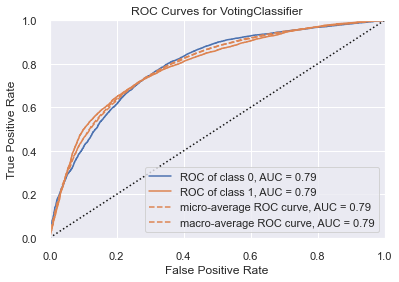

In [25]:
plot_model(best_model, plot="auc")

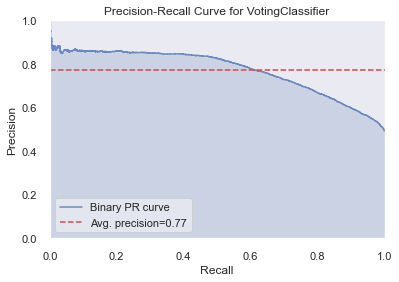

In [26]:
plot_model(best_model, plot="pr")

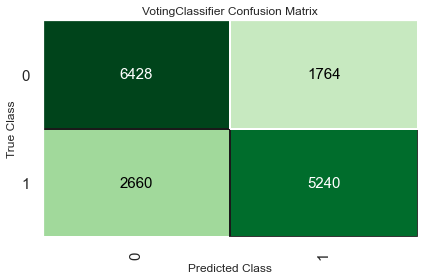

In [27]:
plot_model(best_model, plot="confusion_matrix")

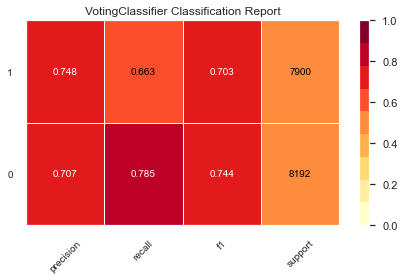

In [28]:
plot_model(best_model, plot="class_report")

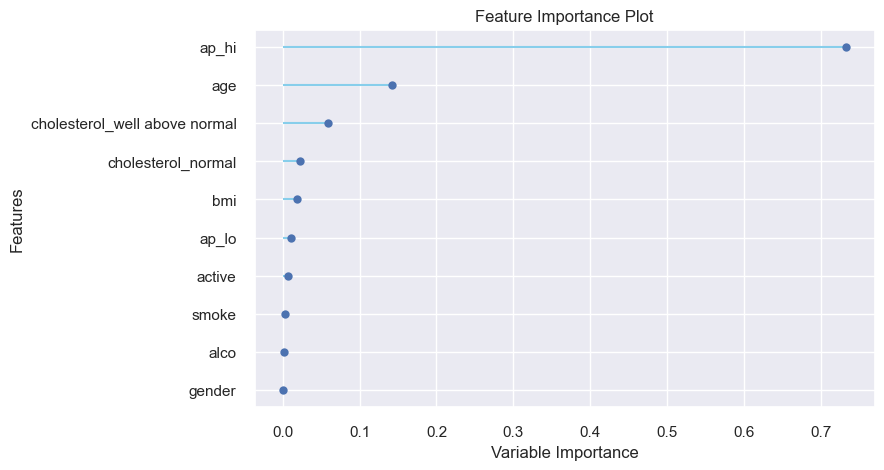

In [29]:
plot_model(top_model, plot = 'feature')

### Prediction on Test Data

In [58]:
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7255,0.7918,0.6652,0.7477,0.7040,0.4496,0.4523


In [30]:
final_model = finalize_model(best_model)

 ### Prediction on Unseen Data

In [34]:
predict_unseen = predict_model(final_model, data=data_unseen);
predict_unseen.head(10)


,age,gender,ap_hi,ap_lo,cholesterol_normal,cholesterol_well above normal,smoke,alco,active,bmi,Label,Score
0,47.799999,1.0,100.0,60.0,1.0,0.0,0.0,0.0,0.0,23.000000,0,0.8468
1,61.799999,0.0,130.0,90.0,0.0,1.0,0.0,0.0,1.0,30.000000,1,0.7842
2,45.900002,1.0,110.0,70.0,1.0,0.0,0.0,0.0,1.0,20.799999,0,0.8538
3,59.599998,0.0,120.0,70.0,1.0,0.0,1.0,0.0,1.0,21.299999,0,0.7443
4,45.500000,1.0,150.0,90.0,0.0,1.0,0.0,0.0,1.0,23.500000,1,0.8793
5,57.700001,0.0,130.0,70.0,1.0,0.0,0.0,0.0,0.0,25.900000,1,0.5322
6,50.099998,1.0,120.0,80.0,0.0,1.0,0.0,0.0,1.0,43.700001,1,0.6292
7,56.500000,1.0,130.0,85.0,1.0,0.0,0.0,0.0,0.0,28.500000,1,0.5620
8,50.700001,0.0,120.0,80.0,1.0,0.0,0.0,0.0,0.0,24.400000,0,0.7120
9,53.299999,0.0,120.0,80.0,1.0,0.0,0.0,0.0,0.0,29.400000,0,0.6122


### Saving Model 

In [36]:
from datetime import date
PATH="../Models/"
save_model(final_model, PATH+"models-v1-"+date.today().strftime("%m-%d-%Y"))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=C:\Users\DELL\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'gender', 'ap_hi', 'ap_lo',
                                              'smoke', 'alco', 'active', 'bmi'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_i...
                                                                                                            n_iter_no_change=None,
                 